## 1. 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression

pd.set_option('max.columns', 100)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

from scipy import stats

In [2]:
def barplot(column):
    sns.barplot(data = data_feature, x = column, y = 'SalePrice')

## 2. 데이터 불러오기

In [3]:
# 데이터 확인
raw_data = pd.read_csv('train.csv')

print('Shape of Data :', raw_data.shape, '\n')
print('-' * 50)
print(raw_data.info())

Shape of Data : (1460, 81) 

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1

## 3. 결측치 처리

In [4]:
object_list = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
               'PoolQC', 'Fence', 'MiscFeature']

# 원래 데이터를 보존하기 위해 새로운 DataFrame 생성
modify_data = raw_data.copy()

# 결측치를 의미하지 않는 값에 'No have' 채워넣기
for feature in object_list:
    null_data = modify_data[feature].isnull().sum()
    print('Number of null values of {} *Before Modify* :'.format(feature), null_data, '\n')
    
    modify_data.loc[modify_data[feature].isnull(), feature] = 'No have'
    
    null_data = modify_data[feature].isnull().sum()
    print('Number of null values of {} *After Modify* :'.format(feature), null_data)
    print('-' * 60)

Number of null values of Alley *Before Modify* : 1369 

Number of null values of Alley *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtQual *Before Modify* : 37 

Number of null values of BsmtQual *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtCond *Before Modify* : 37 

Number of null values of BsmtCond *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtExposure *Before Modify* : 38 

Number of null values of BsmtExposure *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtFinType1 *Before Modify* : 37 

Number of null values of BsmtFinType1 *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtFinType2 *Before Modify* : 38 

Number of null values of BsmtFinType2 *After Modify* : 0
---------------

In [5]:
print('Number of null values of GarageYrBlt *Before Modify* :', modify_data['GarageYrBlt'].isnull().sum(), '\n')

# 결측치 대체
modify_data.loc[modify_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 0
print('Number of null values of GarageYrBlt *After Modify* :', modify_data['GarageYrBlt'].isnull().sum())

Number of null values of GarageYrBlt *Before Modify* : 81 

Number of null values of GarageYrBlt *After Modify* : 0


In [6]:
print('Number of null values of MasVnrType *Before* :', modify_data['MasVnrType'].isnull().sum(), '\n')
print('Number of null values of MasVnrArea *Before* :', modify_data['MasVnrArea'].isnull().sum(), '\n')
print('Number of null values of Electrical *Before* :', modify_data['Electrical'].isnull().sum(), '\n')

modify_data['MasVnrType'].fillna('None', inplace = True)
modify_data['MasVnrArea'].fillna(0, inplace = True)
modify_data['Electrical'].fillna(modify_data['Electrical'].mode()[0], inplace = True)

print('Number of null values of MasVnrType *After* :', modify_data['MasVnrType'].isnull().sum(), '\n')
print('Number of null values of MasVnrArea *After* :', modify_data['MasVnrArea'].isnull().sum(), '\n')
print('Number of null values of Electrical *After* :', modify_data['Electrical'].isnull().sum())

Number of null values of MasVnrType *Before* : 8 

Number of null values of MasVnrArea *Before* : 8 

Number of null values of Electrical *Before* : 1 

Number of null values of MasVnrType *After* : 0 

Number of null values of MasVnrArea *After* : 0 

Number of null values of Electrical *After* : 0


In [7]:
# 'LotFrontage' 변수의 결측치를 예측하기 위한 변수 추출
miss_list = ['Id', 'MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', '1stFlrSF', 
             'BldgType', 'GrLivArea', 'LotArea', 'LotFrontage']

# 데이터 추출
miss_data = modify_data[miss_list]

print('Shape of miss_data :', miss_data.shape)
miss_data.head()

Shape of miss_data : (1460, 10)


,Id,MSSubClass,MSZoning,LotShape,LotConfig,1stFlrSF,BldgType,GrLivArea,LotArea,LotFrontage
0,1,60,RL,Reg,Inside,856,1Fam,1710,8450,65.0
1,2,20,RL,Reg,FR2,1262,1Fam,1262,9600,80.0
2,3,60,RL,IR1,Inside,920,1Fam,1786,11250,68.0
3,4,70,RL,IR1,Corner,961,1Fam,1717,9550,60.0
4,5,60,RL,IR1,FR2,1145,1Fam,2198,14260,84.0


In [8]:
outlier_id = miss_data[miss_data['LotFrontage'] > 300]['Id']

# 'LotFrontage' 변수의 값이 300 넘는 관측치 삭제
miss_data = miss_data[~miss_data['Id'].isin(outlier_id)]
miss_data.reset_index(drop = True, inplace = True)

# 'NewLotShape' 변수 생성
print('Shape of miss_data *Before Create* :', miss_data.shape, '\n')

miss_data['NewLotShape'] = np.nan

for index in miss_data.index:
    
    if miss_data.loc[index, 'LotShape'] == 'Reg':
        miss_data.loc[index, 'NewLotShape'] = 'Reg'
        
    else:
        miss_data.loc[index, 'NewLotShape'] = 'Irreg'
        
print('Shape of miss_data *After Create* :', miss_data.shape, '\n')
print('Unique value of NewLotShape :', miss_data['NewLotShape'].unique())

Shape of miss_data *Before Create* : (1458, 10) 

Shape of miss_data *After Create* : (1458, 11) 

Unique value of NewLotShape : ['Reg' 'Irreg']


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

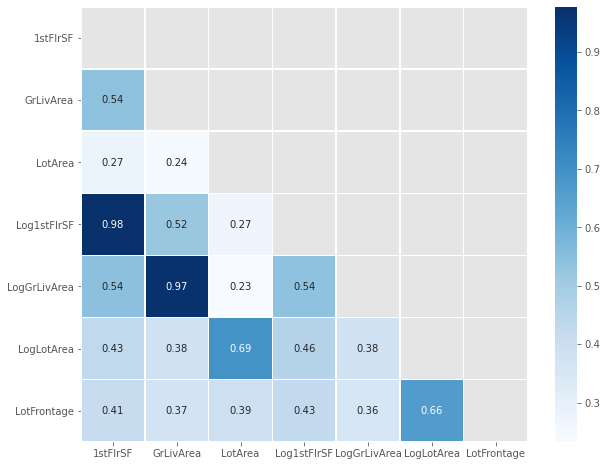

In [9]:
# 연속형 변수를 로그화
miss_data['Log1stFlrSF'] = miss_data['1stFlrSF'].apply(lambda x: np.log1p(x))
miss_data['LogGrLivArea'] = miss_data['GrLivArea'].apply(lambda x: np.log1p(x))
miss_data['LogLotArea'] = miss_data['LotArea'].apply(lambda x: np.log1p(x))

# 로그화 수행 뒤 Heatmap
corr_data = miss_data[['1stFlrSF', 'GrLivArea', 'LotArea', 'Log1stFlrSF',
                       'LogGrLivArea', 'LogLotArea', 'LotFrontage']].corr()

# 'mask' 옵션 설정
mask = np.zeros_like(corr_data, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 시각화 과정
plt.figure(figsize = (10, 8))

sns.heatmap(corr_data, mask = mask, cmap = 'Blues', linewidth = 0.5, annot = True, fmt = ".2f")

In [10]:
# 결측치를 없애기 위해 사용하고자 하는 변수 추출
value_list = ['Id', 'MSSubClass', 'MSZoning', 'NewLotShape', 'LotConfig', 'BldgType',
             'Log1stFlrSF', 'GrLivArea', 'LogLotArea', 'LotFrontage']

pre_miss_data = miss_data[~miss_data['LotFrontage'].isnull()][value_list]
print('Shape of pre_miss_data :', pre_miss_data.shape)

# 'MSSubClass' 변수 문자형 타입으로 변환
pre_miss_data['MSSubClass'] = pre_miss_data['MSSubClass'].astype('str')

pre_miss_data.head()

Shape of pre_miss_data : (1199, 10)


,Id,MSSubClass,MSZoning,NewLotShape,LotConfig,BldgType,Log1stFlrSF,GrLivArea,LogLotArea,LotFrontage
0,1,60,RL,Reg,Inside,1Fam,6.753438,1710,9.042040,65.0
1,2,20,RL,Reg,FR2,1Fam,7.141245,1262,9.169623,80.0
2,3,60,RL,Irreg,Inside,1Fam,6.825460,1786,9.328212,68.0
3,4,70,RL,Irreg,Corner,1Fam,6.869014,1717,9.164401,60.0
4,5,60,RL,Irreg,FR2,1Fam,7.044033,2198,9.565284,84.0


In [11]:
# RandomFroestRegressor 수행
data = pd.get_dummies(pre_miss_data, drop_first = True)

X = data.drop(['Id', 'LotFrontage'], axis = 1)
y = data['LotFrontage']

rf_model = RandomForestRegressor(random_state = 1025).fit(X, y)

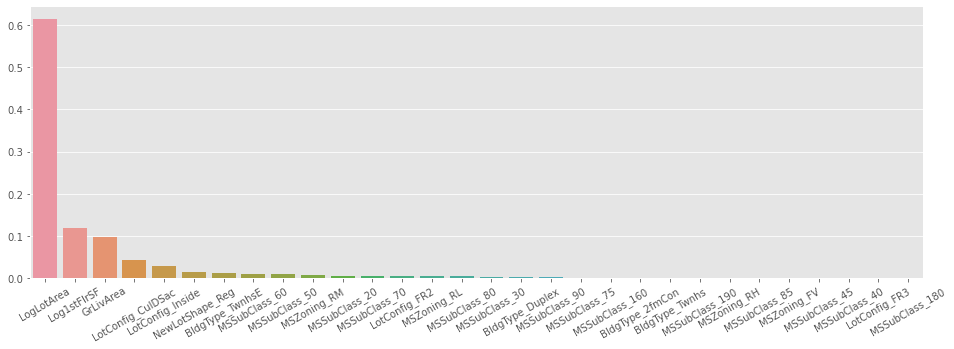

In [12]:
# 변수의 중요도 시각화
feature_data = pd.DataFrame(rf_model.feature_importances_, index = X.columns, columns = ['Importance'])

plt.figure(figsize = (16, 5))

plot_data = feature_data.sort_values(by = 'Importance', ascending = False)

sns.barplot(x = plot_data.index, y = 'Importance', data = plot_data)
plt.xticks(rotation = 30)
plt.ylabel('')
plt.show()

- LogLotArea가 가장 높은 중요도를 나타내기 때문에 LogLotArea로 결측치를 채워주자.
- 이때 채워주기 위해서 knnimputer를 사용하도록 하자.

In [13]:
# 'LotFrontage' 결측치를 대체해주는 함수 만들기
def imputer_lotfrontage(raw_data):
    
    print('Number of null values of LotFrontage *Before Modify* :', raw_data['LotFrontage'].isnull().sum(), '\n')
    
    # 'KNNImputer' 라이브러리 불러오기
    from sklearn.impute import KNNImputer
    
    # 'LotFrontage' 변수에 결측치를 가지는 'Id' 추출 후 저장
    miss_id = raw_data[raw_data['LotFrontage'].isnull()]['Id'].unique()
    
    # 'Id', 'LotFrontage', 'LotArea' 변수 추출 후 저장
    data = raw_data[['Id', 'LotFrontage', 'LotArea']]
    
    # 'LotFrontage' 변수의 값이 300 넘는 관측치를 삭제하기로 했으므로 삭제
    outlier_id = data[data['LotFrontage'] > 300]['Id']
    data = data[~data['Id'].isin(outlier_id)]
    
    # 'Id' 변수를 인덱스로 지정
    data = data.set_index('Id')
    
    # 'LotArea' 변수를 로그화 수행 후, 변수 삭제
    data['LotLogArea'] = data['LotArea'].apply(lambda x: np.log(x))
    data = data.drop('LotArea', axis = 1)
    
    # 모델 객체 생성 후 학습시키고 DataFrame으로 저장
    # 원본 데이터에 결측치로 기입되어 있는 관측치들만 수정해주기 위해 DataFrame을 만들 때, 인덱스를 위 데이터의 인덱스로 지정
    imputer = KNNImputer(n_neighbors = 5)
    pre_data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns, index = data.index)
    
    # 결측치가 존재하던 관측치만 저장
    pre_data = pre_data[pre_data.index.isin(miss_id)]
    
    # 원본 데이터 결측치를 대입해주는 과정
    for id_value, lot_value in zip(pre_data.index, pre_data['LotFrontage']):
        for index in raw_data.index:
            
            if raw_data.loc[index, 'Id'] == id_value:
                raw_data.loc[index, 'LotFrontage'] = lot_value
    
    print('Number of null values of LotFrontage *After Modify* :', raw_data['LotFrontage'].isnull().sum())
 
    return raw_data

In [14]:
# 생성한 함수 적용
modify_data = imputer_lotfrontage(modify_data)

Number of null values of LotFrontage *Before Modify* : 259 

Number of null values of LotFrontage *After Modify* : 0


- knnimputer를 이용하여 모든 결측치를 처리해 주었다.

In [15]:
# 순서형 변수 중 문자열 타입으로 되어있는 변수를 변환
# 'ExterQual' & 'ExterCond'
mapping = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1}

modify_data['ExterQual'] = modify_data['ExterQual'].map(mapping)
modify_data['ExterCond'] = modify_data['ExterCond'].map(mapping)

# 'BsmtQual' & 'BsmtCond'
mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['BsmtQual'] = modify_data['BsmtQual'].map(mapping)
modify_data['BsmtCond'] = modify_data['BsmtCond'].map(mapping)

# 'HeatingQC'
mapping = {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['HeatingQC'] = modify_data['HeatingQC'].map(mapping)

# 'KitchenQual'
mapping = {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['KitchenQual'] = modify_data['KitchenQual'].map(mapping)

# 'FireplaceQu'
mapping = mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['FireplaceQu'] = modify_data['FireplaceQu'].map(mapping)

# 'GarageQual' & 'GarageCond'
mapping = mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['GarageQual'] = modify_data['GarageQual'].map(mapping)
modify_data['GarageCond'] = modify_data['GarageCond'].map(mapping)

# 'PoolQC'
mapping = mapping = {'No have' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4}

modify_data['PoolQC'] = modify_data['PoolQC'].map(mapping)

In [16]:
print('Number of incorrectly entered value *Wd Shng* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Wd Shng']), '\n')

print('Number of incorrectly entered value *CmentBd* :',
      len(modify_data[modify_data['Exterior2nd'] == 'CmentBd']), '\n')

print('Number of incorrectly entered value *Brk Cmn* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Brk Cmn']))

Number of incorrectly entered value *Wd Shng* : 38 

Number of incorrectly entered value *CmentBd* : 60 

Number of incorrectly entered value *Brk Cmn* : 7


In [17]:
modify_data.loc[modify_data['Exterior2nd'] == 'Wd Shng', 'Exterior2nd'] = 'Wd Sdng'
modify_data.loc[modify_data['Exterior2nd'] == 'CmentBd', 'Exterior2nd'] = 'CemntBd'
modify_data.loc[modify_data['Exterior2nd'] == 'Brk Cmn', 'Exterior2nd'] = 'BrkComm'

print('Number of incorrectly entered value *Wd Shng* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Wd Shng']), '\n')

print('Number of incorrectly entered value *CmentBd* :',
      len(modify_data[modify_data['Exterior2nd'] == 'CmentBd']), '\n')

print('Number of incorrectly entered value *Brk Cmn* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Brk Cmn']))

Number of incorrectly entered value *Wd Shng* : 0 

Number of incorrectly entered value *CmentBd* : 0 

Number of incorrectly entered value *Brk Cmn* : 0


- 모든 결측치를 제거해 주었다.
- 이젠 변수를 살펴보며 의미있는 변수들을 만들어 주자.

In [18]:
# 결측치 제거한 데이터를 final_data로 바꿔주자.
final_data = modify_data.copy()

In [19]:
print('Shape of final_data *Before Create* :', final_data.shape, '\n')

# 'NewCondition1' 변수 생성
final_data['NewCondition1'] = np.nan

for index in final_data.index:
    
    value = final_data.loc[index, 'Condition1']
    
    if (value == 'Artery') | (value == 'Feedr'):
        final_data.loc[index, 'NewCondition1'] = 'Street'
        
    elif (value == 'PosN') | (value == 'PosA'):
        final_data.loc[index, 'NewCondition1'] = 'Positive'
        
    elif value == 'Norm':
        final_data.loc[index, 'NewCondition1'] = 'Norm'
        
    else:
        final_data.loc[index, 'NewCondition1'] = 'Rail'
        
print('Unique values of NewCondition1 :', final_data['NewCondition1'].unique(), '\n')

# 'CountCon' 변수 생성
final_data['CountCon'] = np.nan

for index in final_data.index:
    
    first_value = modify_data.loc[index, 'Condition1']
    second_value = modify_data.loc[index, 'Condition2']
    
    # 'Condition1'과 'Condition2' 변수 모두 'Norm'인 경우
    if (first_value == 'Norm') & (second_value == 'Norm'):
        final_data.loc[index, 'CountCon'] = 0
    
    else:
        final_data.loc[index, 'CountCon'] = 1

print('Unique values of CountCon :', final_data['CountCon'].unique(), '\n')
print('Shape of final_data *After Create* :', final_data.shape)

Shape of final_data *Before Create* : (1460, 81) 

Unique values of NewCondition1 : ['Norm' 'Street' 'Positive' 'Rail'] 

Unique values of CountCon : [0. 1.] 

Shape of final_data *After Create* : (1460, 83)


In [20]:
# 'SameExterior' 변수 생성
print('Shape of final_data *Before Create* :', final_data.shape, '\n')

final_data['SameExterior'] = np.nan

for index in final_data.index:
    
    first_exterior = final_data.loc[index, 'Exterior1st']
    second_exterior = final_data.loc[index, 'Exterior2nd']
    
    if first_exterior == second_exterior:
        final_data.loc[index, 'SameExterior'] = 1
    
    else:
        final_data.loc[index, 'SameExterior'] = 0
        
print('Shape of final_data *After Create* :', final_data.shape, '\n')
print('Unique vlaues of SameExterior :', final_data['SameExterior'].unique())

Shape of final_data *Before Create* : (1460, 83) 

Shape of final_data *After Create* : (1460, 84) 

Unique vlaues of SameExterior : [1. 0.]


In [21]:
# 데이터를 쉽게 사용하기 위해서 final_data를 train으로 바꿔주자.
train = final_data.copy()

In [22]:
train.MSSubClass=train.MSSubClass.astype('object')

mapping = {'No have':0,'No':1, 'Mn':2, 'Av':3, 'Gd':4}
train['BsmtExposure'] = train['BsmtExposure'].map(mapping)
mapping = {'No have':0,'LwQ':1, 'Rec':2,'BLQ':3,'ALQ':4,'Unf':5,'GLQ':6}
train['BsmtFinType1'] = train['BsmtFinType1'].map(mapping)
train['BsmtFinType2'] = train['BsmtFinType2'].map(mapping)
mapping = {'Y':1, 'N':0}
train['CentralAir'] = train['CentralAir'].map(mapping)
mapping = {'No have':0,'Unf':1, 'RFn':2, 'Fin':3}
train['GarageFinish'] = train['GarageFinish'].map(mapping)
mapping = {'N':0,'P':1,'Y':2}
train['PavedDrive'] = train['PavedDrive'].map(mapping)
mapping = {'No have':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
train['Fence'] = train['Fence'].map(mapping)

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


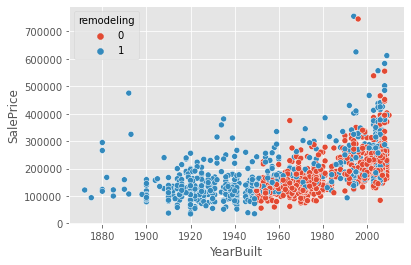

In [23]:
# YearRemodAdd와 YearBuilt를 이용하여 remodeling의 여부를 파악해보자.
train['remodeling'] = 0
for i in train.index:
    if train.loc[i,'YearBuilt'] == train.loc[i,'YearRemodAdd']:
        train.loc[i,'remodeling'] = 0
    else:
        train.loc[i,'remodeling'] = 1

# 1940년도에 지어진 건물은 거의다 remodeling을 했다.
sns.scatterplot(data = train, x = 'YearBuilt', y = 'SalePrice', hue = 'remodeling')

Text(0.5, 1.0, 'non remodeling')

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


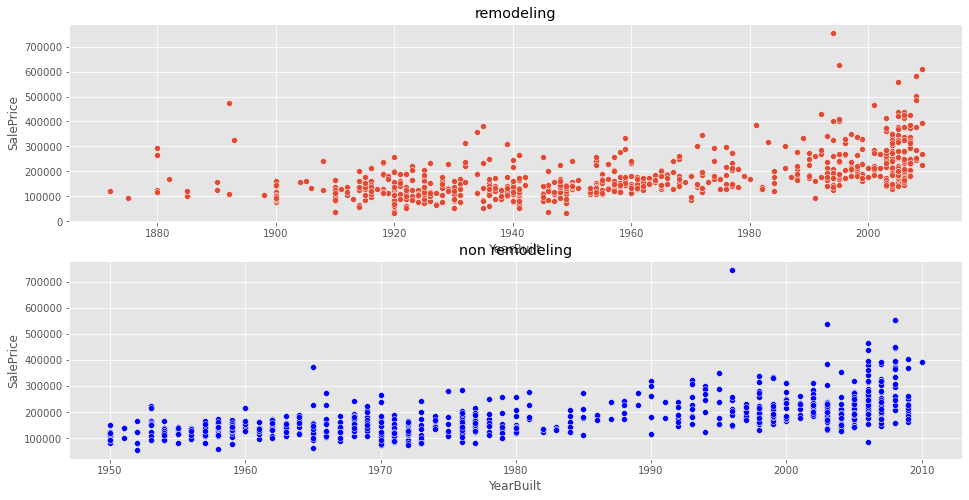

In [24]:
# 리모델링을 했는지의 여부에 따라서 YearBuilt가 달라지는지 확인해보자.
train_remodeling_1 = train[train['remodeling'] == 1]
train_remodeling_0 = train[train['remodeling'] == 0]

fig, ax = plt.subplots(nrows = 2, figsize = (16,8))
sns.scatterplot(data = train_remodeling_1, x = 'YearBuilt', y = 'SalePrice', ax = ax[0])
ax[0].set_title('remodeling')

sns.scatterplot(data = train_remodeling_0, x = 'YearBuilt', y = 'SalePrice', color = 'b',ax =ax [1])
ax[1].set_title('non remodeling')

<AxesSubplot:xlabel='remodeling', ylabel='SalePrice'>

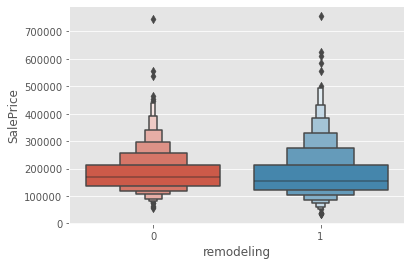

In [25]:
# boxenplot을 이용하여 리모델링 여부가 가격에 영향을 미치는지 확인해보자.
sns.boxenplot(data = train, x = 'remodeling', y = 'SalePrice')

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

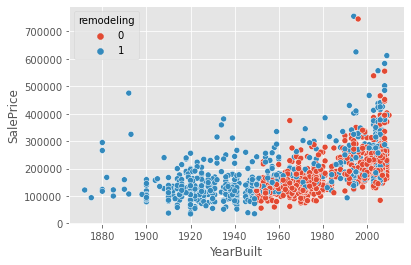

In [26]:
# 우리는 리모델링이 어떻게 데이터가 형성되어있는지 확인해보자.
sns.scatterplot(data = train, x = 'YearBuilt', y = 'SalePrice', hue = 'remodeling')

<AxesSubplot:xlabel='Year_1950', ylabel='SalePrice'>

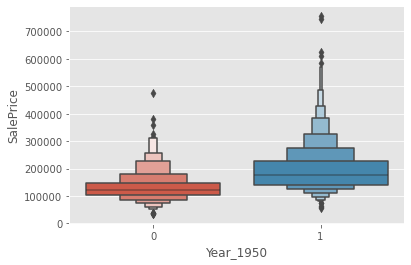

In [27]:
# 1950년 이하의 집은 리모델링을 전부 해줬기 때문에 우리는 1950년도 이상 이하를 이용하여 Year_1950이라는 변수를 만들어주도록 하자.ㅏ
train['Year_1950'] = train['YearBuilt'].apply(lambda x: 1 if x >= 1950 else 0)
sns.boxenplot(data = train, x = 'Year_1950', y = 'SalePrice')

- 확실히 1950년도 이전의 건물과 이후의 건물은 가격면에서 차이가 있다.
- 그러면 우리는 데이터를 범주화 해주도록 하자.
- 1. 1950년 이전의 건물을 0
- 2. 1950년 이후의 건물 중 리모델링을 안한 건물 1
- 3. 1950년 이후에 건물 중 리모델링을 한 건물 2

<AxesSubplot:xlabel='New_Year_feature', ylabel='SalePrice'>

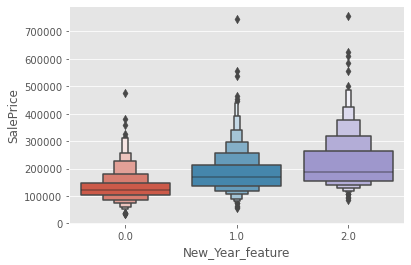

In [28]:
# 확실히 1950년도 이전의 건물과 이후의 건물이 가격면에서 차이가 있었고 remodeling의 변화를 파악하기 위해서 우리는 New_Year_feature라는 변수를 만들어 주도록 하자.
# 1. 1950년 이전의 건물을 0
# 2. 1950년 이후의 건물 중 리모델링을 안한 건물 1
# 3. 1950년 이후에 건물 중 리모델링을 한 건물 2
train['New_Year_feature'] = np.nan
for i in train.index:
    # 처음에 1950년도 이전의 건물을 뽑아내서 0을 할당한다.
    if train.loc[i,'Year_1950'] == 0:
        train.loc[i,'New_Year_feature'] = 0
    else:
    # 1950년도 이상의 건물중에서 remodeling 값이 0이면 1 1이면 2를 할당한다.
        if train.loc[i,'remodeling'] == 0:
            train.loc[i,'New_Year_feature'] = 1
        else:
            train.loc[i,'New_Year_feature'] = 2
            
sns.boxenplot(data = train, x = 'New_Year_feature', y = 'SalePrice')
# 이 변수는 각 값마다 확연한 차이가 있으므로 변수에 넣기로 했다.

BsmtBath_counts의 값 : [1. 0. 2. 3.]
Bath_counts의 값 : [3. 2. 1. 4. 0.]


Text(0.5, 1.0, 'Bath_counts vs SalePrice')

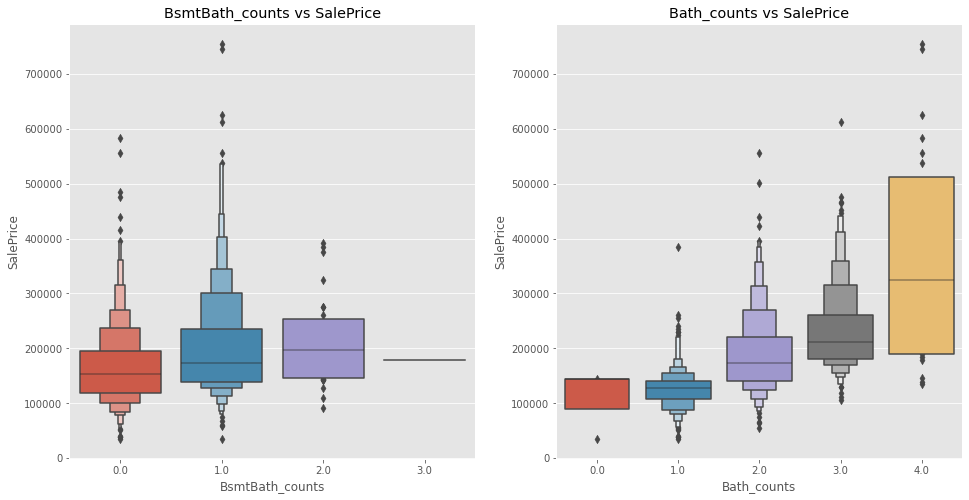

In [29]:
# 지하 화장실의 갯수를 BsmtBath_counts라는 변수로 만들어준다.
# 화장실의 갯수를 Bath_counts라는 변수로 만들어준다.
for i in train.index:
    train.loc[i,'BsmtBath_counts'] = train.loc[i,'BsmtFullBath']+train.loc[i,'BsmtHalfBath']
    train.loc[i,'Bath_counts'] = train.loc[i,'FullBath'] + train.loc[i,'HalfBath']

# 화장실의 갯수를 만든 변수들을 지워준다.
train = train.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis = 1)

# 변수들을 확인한다.
print('BsmtBath_counts의 값 :',train['BsmtBath_counts'].unique())
print('Bath_counts의 값 :', train['Bath_counts'].unique())

# boxenplot으로 SalePrice와의 관계를 확인한다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.boxenplot(data = train, x = 'BsmtBath_counts', y = 'SalePrice', ax = ax[0])
ax[0].set_title('BsmtBath_counts vs SalePrice')

sns.boxenplot(data = train, x = 'Bath_counts', y = 'SalePrice', ax = ax[1])
ax[1].set_title('Bath_counts vs SalePrice')

<AxesSubplot:xlabel='Garage_in', ylabel='SalePrice'>

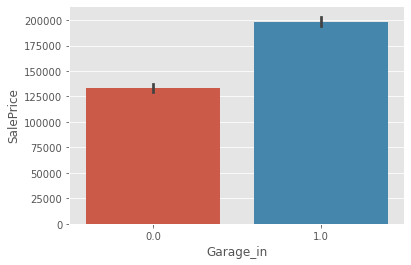

In [30]:
# CarPort와 Detchd는 집과 떨어진 주차장임으로 이것을 제외한 나머지는 Garage_in이라는 변수를 만들어주자.
train.loc[(train['GarageType'] != 'Detchd')& (train['GarageType'] != 'CarPort'),'Garage_in'] = 1
train.loc[(train['GarageType'] == 'Detchd')|(train['GarageType'] == 'CarPort'), 'Garage_in'] = 0

# 그래프를 그려보면 Garage가 집 안에 있는 경우가 더 많은 SalePrice를 갖는다.
sns.barplot(data = train, x = 'Garage_in', y = 'SalePrice')

<AxesSubplot:xlabel='Garage_exist', ylabel='SalePrice'>

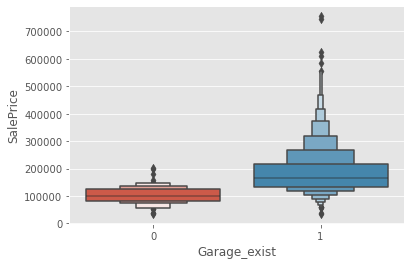

In [31]:
# Garage가 있을 때와 없을 때의 가격을 비교하기 위해 Garage_exist라는 변수를 만들어 준다.
train['Garage_exist'] = train['GarageYrBlt'].apply(lambda x:1 if x > 0 else 0)

sns.boxenplot(data = train, x = 'Garage_exist', y = 'SalePrice')

<AxesSubplot:xlabel='MasVnrArea_exist', ylabel='SalePrice'>

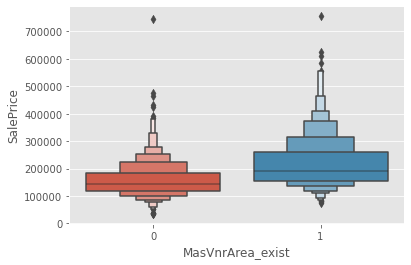

In [32]:
# MasVnrArea를 가지고 있는지 없는지로 변수를 만들어 준다.
train['MasVnrArea_exist'] = train['MasVnrArea'].apply(lambda x:1 if x > 0 else 0)
train=train.drop('MasVnrArea', axis = 1)

sns.boxenplot(data = train, x = 'MasVnrArea_exist', y = 'SalePrice')

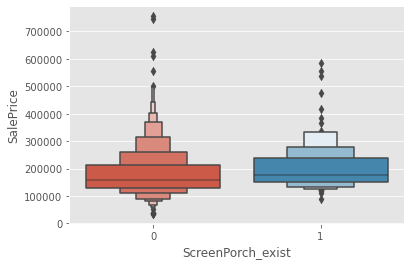

In [33]:
# ScreenPorch가 존재하는 것과 존재하지 않는 것으로 나눠준다.
train['ScreenPorch_exist'] = train['ScreenPorch'].apply(lambda x:1 if x > 0 else 0)
sns.boxenplot(data = train, x = 'ScreenPorch_exist', y = 'SalePrice')
# ScreenPorch가 1인 데이터가 더 높은 가격을 형성하는 것을 볼 수 있다.
train=train.drop('ScreenPorch', axis = 1)

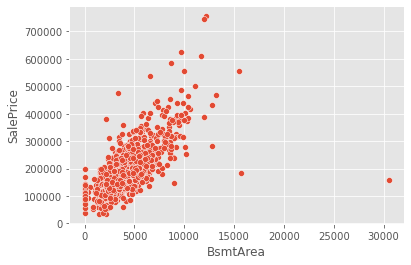

In [34]:
# 지하실의 높이와 지하 총 평방피트를 곱해서 BsmtArea라는 지하의 부피를 구해준다.
for i in train.index:
    train.loc[i,'BsmtArea'] = train.loc[i,'BsmtQual'] * train.loc[i,'TotalBsmtSF']
    
# 그래프를 그려서 관계가 있는지 확인한다.
sns.scatterplot(data = train, x = 'BsmtArea', y = 'SalePrice')

# 다중공선성이 걸리지 않게 변수를 제거해 준다.
train=train.drop(['BsmtQual','TotalBsmtSF'], axis =1)

In [35]:
# object인 column만 뽑아서 라벨 인코딩을 진행해 준다.
a = []
for i in train.columns:
    if train[i].dtype == 'object':
        a.append(i)
        
le = LabelEncoder()
for i in a:
    train[i] = le.fit_transform(train[i])

In [36]:
# 필요하지 않은 변수들이라고 생각되는 변수들을 제거해준다.
train = train.drop(['remodeling','YearRemodAdd','Year_1950','Id'], axis = 1)
train = train.drop(['Exterior1st','Exterior2nd'], axis = 1)
train = train.drop(['GarageCars','Alley'], axis = 1)
train = train.drop(['Condition1','Condition2'], axis = 1)
train = train.drop('Utilities', axis = 1)

# 이상치가 너무 많은 데이터임으로 정규화를 통해서 분석에 용이하게 만든다.
train['SalePrice'] = train['SalePrice'].apply(lambda x: np.log1p(x))

# 연속형 변수들에 로그화 해준다.
train['LotArea'] = train['LotArea'].apply(lambda x:np.log1p(x))
train['GarageArea'] = train['GarageArea'].apply(lambda x:np.log1p(x))
train['GrLivArea'] = train['GrLivArea'].apply(lambda x:np.log1p(x))
train['LotFrontage'] = train['LotFrontage'].apply(lambda x: np.log1p(x))
train['BsmtArea'] = train['BsmtArea'].apply(lambda x: np.log1p(x))

# quality데이터를 각 값에 범주화 되어있는 개수를 나눠준다. 즉, quality데이터를 가지고 하나의 변수를 만들어준다.
quality_data=['OverallQual','ExterQual','KitchenQual','FireplaceQu','GarageQual']
train['quality'] = 0
for i in quality_data:
    train['quality'] += train[i].apply(lambda x: x/len(train[i].unique()))
    train=train.drop(i,axis = 1)

           quality  SalePrice
quality    1.00000    0.82022
SalePrice  0.82022    1.00000


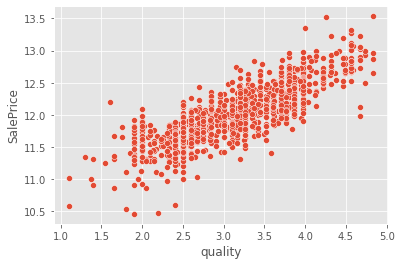

In [37]:
# quality 변수와 SalePrice의 상관관계를 확인해 본다.
sns.scatterplot(data = train, x = 'quality', y = 'SalePrice')
print(train[['quality','SalePrice']].corr())

In [38]:
# 변수가 모델에 넣을 수 있도록 int나 float으로 바뀌었는지 확인한다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   int32  
 1   MSZoning           1460 non-null   int32  
 2   LotFrontage        1460 non-null   float64
 3   LotArea            1460 non-null   float64
 4   Street             1460 non-null   int32  
 5   LotShape           1460 non-null   int32  
 6   LandContour        1460 non-null   int32  
 7   LotConfig          1460 non-null   int32  
 8   LandSlope          1460 non-null   int32  
 9   Neighborhood       1460 non-null   int32  
 10  BldgType           1460 non-null   int32  
 11  HouseStyle         1460 non-null   int32  
 12  OverallCond        1460 non-null   int64  
 13  YearBuilt          1460 non-null   int64  
 14  RoofStyle          1460 non-null   int32  
 15  RoofMatl           1460 non-null   int32  
 16  MasVnrType         1460 

In [39]:
# train과 target변수로 바꾸어서 모델에 넣을 준비를 한다.
target=train.loc[:,'SalePrice']
train = train.drop('SalePrice', axis = 1)

# 데이터 중요 feature 추출

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, train_test_split

In [41]:
# 변수를 train과 test셋으로 나누어서 LinearRegression으로 확인한다.
X_train, X_test, y_train,y_test = train_test_split(train,target, test_size = 0.2, random_state = 42)

lr=LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)

RMSE=mean_squared_error(y_pred, y_test)**0.5
print('LinearRegression :', RMSE)

LinearRegression : 0.14454304257260825


In [42]:
# 중요 변수를 추출하기 위해서 statsmodels로 변수들의 P-value를 확인한다.
import statsmodels.api as sm

X = sm.add_constant(X_train)
y = y_train

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())
results.pvalues

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     123.0
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        16:34:44   Log-Likelihood:                 714.64
No. Observations:                1168   AIC:                            -1287.
Df Residuals:                    1097   BIC:                            -927.8
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.9046      6.43

const                2.831123e-01
MSSubClass           9.346001e-03
MSZoning             1.190524e-01
LotFrontage          3.609156e-01
LotArea              2.034283e-07
                         ...     
Garage_exist         6.885313e-01
MasVnrArea_exist     3.536319e-01
ScreenPorch_exist    4.489653e-03
BsmtArea             1.126627e-02
quality              1.743607e-28
Length: 71, dtype: float64

In [43]:
# p-value가 0.05이상인 변수를 제거해 준다.
data_feature=pd.DataFrame(results.pvalues)
data_feature=data_feature.rename(columns = {0:'feature'})

a = []
for index,feature in zip(data_feature.index, data_feature['feature']):
    if feature > 0.05:
        pass
    else:
        if index != 'const':
            a.append(i)

In [44]:
# 변수를 제거 한 이후에 다시 한번 LinearRegression으로 모델을 돌려본다.
X_train, X_test, y_train,y_test = train_test_split(data_feature,target, test_size = 0.2, random_state = 42)
lr=LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)

RMSE=mean_squared_error(y_pred, y_test)**0.5
print('LinearRegression :', RMSE)

ValueError: Found input variables with inconsistent numbers of samples: [71, 1460]

## p-value로 추출한 변수들로 다시 한번 전처리를 진행한다.

In [ ]:
# 전처리를 진행하기 위해서 변수를 데이터프레임에 넣어준다.
data_feature=pd.concat([data_feature,target], axis = 1)

In [ ]:
# SalePrice의 분포를 확인한다.
plt.figure(figsize = (16,8))
sns.distplot(data_feature['SalePrice'])
plt.title('SalePrice distribution')

In [ ]:
# 결측치가 없는지 확인한다.
data_feature.isnull().sum()

## 두개의 변수로 찾아보기

In [ ]:
data_feature.columns
data_feature['New_Year_feature'] = train['New_Year_feature']

In [ ]:
plt.figure(figsize = (24,12))
data_feature_corr=data_feature.corr()
sns.heatmap(data_feature_corr, annot = True)

## 다중공산성 확인해보기

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(data_feature.drop('SalePrice', axis = 1))
y = data_feature['SalePrice']

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

In [ ]:
# VIF를 이용하여 다중공선성을 확인해주려고 했지만 VIF Factor가 높은 변수들은 필요하다고 판단해서 제거하지 않기로 했다.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(data_feature.drop('SalePrice', axis = 1).values, i) for i in range(data_feature.drop('SalePrice',axis = 1).shape[1])]
vif['features'] = data_feature.drop('SalePrice',axis =1).columns
vif

In [ ]:
# LotArea와 SalePrice를 비교해본다.
sns.scatterplot(data = data_feature, x = 'LotArea', y = 'SalePrice')
plt.title('LotArea vs SalePrice')

In [ ]:
# MSSubClass와 SalePrice를 비교해본다.
sns.barplot(data = data_feature, x = 'MSSubClass', y = 'SalePrice')

In [ ]:
# YearBuilt와 SalePrice를 Foundation별로 비교해 본다.
sns.scatterplot(data = data_feature, x = 'YearBuilt', y = 'SalePrice', hue = 'Foundation')

# YearBuilt 1940년 이전 1940~1990사이 1990 이상 의 데이터들은 각 Foundation을 대표한다고 판단했고 년도별로 나눠주었다.
# YearBuilt를 Foundation을 기준으로 잘라준다.
data_feature.loc[data_feature['YearBuilt'] <= 1940,'Year_Foundation']  = 0
data_feature.loc[(data_feature['YearBuilt'] >= 1940) &(data_feature['YearBuilt'] < 1990), 'Year_Foundation'] = 1
data_feature.loc[(data_feature['YearBuilt'] >= 1990) , 'Year_Foundation'] = 2
data_feature=data_feature.drop('Foundation', axis = 1)

In [ ]:
sns.barplot(data = data_feature, x = 'Year_Foundation', y = 'SalePrice')

In [ ]:
# SaleCondition과 SalePrice를 비교해준다.
sns.boxenplot(data = data_feature, x = 'SaleCondition', y = 'SalePrice')

# 특징을 발견하지 못해서 지워주도록 하자.

## 2ndFlrSF

In [ ]:
# 2ndFlrSF와 SalePrice를 비교해준다.
sns.scatterplot(data = data_feature, x = '2ndFlrSF',y = 'SalePrice')

# 0에 몰려있는 데이터가 많기 때문에 2층이 있으면 1 없으면 0으로 바꿔준다.
data_feature['2_floor_exist'] = data_feature['2ndFlrSF'].apply(lambda x:1 if x >0  else 0)

# 1과 0 사이에 차이가 있다.
sns.boxenplot(data = data_feature, x = '2_floor_exist', y = 'SalePrice')

# 다중공선성을 피하기 위해서 변수를 제거해 준다.
data_feature = data_feature.drop('2ndFlrSF', axis = 1)

## KitchenAbvGr

In [ ]:
# KitchenAbvGr과 SalePrice를 비교해준다.
sns.boxenplot(data = data_feature, x = 'KitchenAbvGr', y = 'SalePrice')

# 특징이 있는 변수라고 판단되지 않았고 변수를 제거해 주도록 하자.
data_feature=data_feature.drop('KitchenAbvGr', axis = 1)

## HeatingQC

In [ ]:
# HeatingQC와 SalePrice를 비교해준다.
# HeatingQC가 올라갈수록 높은 가격을 형성함으로 지워주지 않도록 한다.
sns.boxenplot(data = data_feature, x = 'HeatingQC', y = 'SalePrice')

## FirePlaces

In [ ]:
# FirePlaces와 SalePrice를 비교해준다.
# Fireplaces의 값이 올라갈수록 높은 SalePrice를 갖는다.
sns.boxenplot(data = data_feature, x = 'Fireplaces', y = 'SalePrice')

## Stacking ensemble을 사용한 모델링

In [ ]:
from sklearn.linear_model import Ridge,Lasso,HuberRegressor,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

models={'lgb':LinearRegression(),'Ridge':Ridge(),'Lasso':Lasso(),'rgb':RandomForestRegressor(), 'cat':CatBoostRegressor()}
def good_models(models, data = None, target = None):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
    model_rmse = {}
    for model in models:
        models[model].fit(X_train, y_train)
        y_pred=models[model].predict(X_test)
        model_rmse[model] = y_pred
    
    return model_rmse

In [ ]:
best_model=good_models(models = models,data = data_feature.drop('SalePrice', axis = 1), 
            target = data_feature['SalePrice'])

In [ ]:
model_value = pd.DataFrame()
for key, value in best_model.items():
    model_value[key] = value

In [ ]:
model_value

In [ ]:
best_model = pd.DataFrame(best_model.items())

In [ ]:
final_cat = XGBRegressor()
final_cat.fit(model_value, y_test)
final=final_cat.predict(model_value)

In [ ]:
RMSE = mean_squared_error(final, y_test)**0.5
print(RMSE)